In [1]:
import numpy as np
import geopandas as gpd
from scipy.spatial import KDTree
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter
from fuzzywuzzy import process
import contextily as cx

import warnings, traceback

from IndexUtils import * 
from TileUtils import *
from featurematching import *
from ReadDate import *
from concurrent.futures import ThreadPoolExecutor

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
from scipy.spatial.distance import cdist
import easyocr
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.ndimage import center_of_mass

from sklearn.cluster import DBSCAN

from skimage.morphology import skeletonize

from scipy.interpolate import Rbf


%load_ext autoreload
%autoreload 2

C:\Users\fhacesga\AppData\Local\Temp\ipykernel_24520\3096312912.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


In [37]:
def processHalfSize(tiles, half_path):
    processing_images=[]
    for tile in tqdm(tiles):
        half_out_fn = os.path.join(half_path, os.path.basename(tile))
        processing_images.append(half_out_fn)
        if not os.path.exists(half_out_fn):
            a    = cv2.imread(tile)
            half = cv2.resize(a,  (0, 0), fx=0.5, fy=0.5)
            cv2.imwrite(half_out_fn, half)

def processSAHIresults(yolo_path, streetcorner_out_fn):
    def get_largest_subdirectory(base_dir):
        subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        numbered_subdirs = [(d, int(d.replace('exp', ''))) for d in subdirs if d.startswith('exp') and d[3:].isdigit()]
        largest_subdir = max(numbered_subdirs, key=lambda x: x[1])[0] if numbered_subdirs else None
        return os.path.join(base_dir, largest_subdir)

    pkldir    = os.path.join(get_largest_subdirectory(yolo_path), "pickles\\")
    print(f"Reading results from: {pkldir}" )

    pkl_files = glob.glob(pkldir + "*")

    streetcorner_dict = {}

    for pkl in pkl_files:
        with open(pkl, 'rb') as f:
            x = pickle.load(f)

        streetcorner_dict[os.path.basename(pkl)] = np.array([calcCenter(a.bbox.to_xyxy()) for a in x])

    pickle.dump(streetcorner_dict, open(streetcorner_out_fn, "wb" ) )

    return streetcorner_dict
    

def processTiledYOLOs(tiles, model_paths, out_dict_names, proc_dir, imsizes):

    print("Making images half size for tiled inference")
    half_path = os.path.join(proc_dir, "half_size")
    os.makedirs(half_path, exist_ok=True)
    processHalfSize(tiles, half_path)
    
    out_dicts = []

    for i, model_path in enumerate(model_paths): 

        yolo_path = os.path.join(proc_dir, out_dict_names[i])
        os.makedirs(yolo_path, exist_ok=True)

        out_fn = os.path.join(proc_dir, f"{out_dict_names[i]}.pkl")
        
        if not os.path.exists(out_fn):
            
            detection_model = AutoDetectionModel.from_pretrained(
                model_type="yolov8",
                model_path=model_path,
                confidence_threshold=0.001,
                device="cuda",  # or 'cuda:0'
            )
            
            result = predict(source=half_path,
                            detection_model=detection_model, 
                            verbose=0, 
                            project=yolo_path,
                            slice_height=imsizes[i], 
                            slice_width=imsizes[i], 
                            model_device="cuda", 
                            return_dict=True, 
                            export_pickle=True,
                            visual_hide_labels=True)
            
            curr_dict = processSAHIresults(yolo_path, out_fn)
        else:
            print(f"Reading from {out_fn}")
            curr_dict = pickle.load(open(out_fn, "rb"))

        out_dicts.append(curr_dict)
    
    return out_dicts


In [39]:
base_input_path = r"D:\RECTDNN\uncompress\\"
# LIST ALL IMAGES IN DIRECTORY
image_files = []
wildcards = ['480287', '48201', '480296']

# wildcards = ['480296']
for w in wildcards:
    # print(f"Potential detections {w}: {len([a for a in list(tile_coords.keys()) if w in a])}")
    # print([a for a in list(tile_coords.keys()) if w in a])
    image_files.extend(glob.glob(f"{base_input_path}/*{w}*"))
image_files = [f for f in image_files if 'w' not in os.path.splitext(f)[1]]

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*" + pattern + "*.*[!w]*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

In [3]:
# model_paths = [
#     r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CCNN\CCNN_medium.pt",
#     r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt"
# ]
model_paths = [
    r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt"
]

proc_dir = r"D:\RECTDNN\processing\newtest\\"

out = processTiledYOLOs(tiles, model_paths, ['CornerCoordinates',], proc_dir, imsizes=[320])
# Performing inference on images:  73%|███████▎  | 625/859 [54:31<20:24,  5.23s/it]

NameError: name 'tiles' is not defined

In [ ]:
"""
ori_model = TPNN(num_classes=3, finalpadding=1, inputsize=2)
ori_checkpoint = torch.load(r'C:\Users\fhacesga\Desktop\FIRMsDigitizing\data\FLNN/checkpoint_021524.pth')
ori_model.load_state_dict(ori_checkpoint['model_state_dict'])

checkpoint = torch.load(r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\data\FLNN\checkpoint_111824_tiled_2.pth")
model = WrapperTPNN(ori_model, input_channels=1, target_channels=2)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to('cuda')
"""

In [2]:
from TPNN import *

In [25]:
def split_and_run_cnn_wrapper(image, model, tilesize=512, device="cuda", verbose=True):

    tensor = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    if np.asarray(image).ndim == 3:
        image = np.asarray(image)[:, :, 0]

    # CALCULATE HOW MANY TILES WE NEED IN X AND Y DIRECTIONS
    width, height = image.shape
    num_tiles_x = (width + tilesize-1) // tilesize
    num_tiles_y = (height + tilesize-1) // tilesize
    
    # OUTPUT STRUCTURES
    output_tiles = []
    output_gen = np.zeros((width, height, model.tpnn.num_classes))
    
    # FOR EACH TILE
    for tile_x in tqdm(range(num_tiles_x), disable=(not verbose)):
        for tile_y in range(num_tiles_y):
                        
            # COORDINATES OF CURRENT TILE
            x0 = tile_x * tilesize
            y0 = tile_y * tilesize
            x1 = min(x0 + tilesize, width)
            y1 = min(y0 + tilesize, height)
            x_pad = x1 - x0
            y_pad = y1 - y0

            print(x0, x1, y0, y1, x_pad, y_pad)
            tile = np.zeros((tilesize, tilesize))
            tile[:x_pad, :y_pad] = image[x0:x1, y0:y1]
            
            # TILE PREPROCESSING
            tile = np.array(tile)                               # AS NUMPY ARRAY
            tile = tile * 255 if np.max(tile) == 1 else tile    # SCALE TO UINT 8
            tile = tile.astype(np.uint8)                        # CHANGE DATA TYPE
            tile_tensor = tensor(tile).unsqueeze(0).to(device)  # TO DEVICE

            # RUN CNN ON TILE
            output = model(tile_tensor)
            
            # PROCESS OUTPUTS OUT OF DEVICE
            if device == "cuda":
                output = output[0, :, :, :].cpu().detach().numpy()
            else:
                output = output[0, :, :, :].detach().numpy()
            
            # POSTPROCESS 
            output = np.moveaxis(output, [0], [2])                      # CHANGE CHANNELS SO BANDS ARE IN LAST DIMENSION
            output_tiles.append(output.copy())                          # APPEND TILE TO LIST
            
            # PUT IT WITH THE REST
            output_gen[x0:x1, y0:y1, :] = output[:x_pad, :y_pad, :]
        
        del output, tile, tile_tensor
        torch.cuda.empty_cache()
    return output_gen, output_tiles

def split_and_run_cnn_with_overlap(image, model, tilesize=512, overlap=256, device="cuda", verbose=True):
    import torch
    import numpy as np
    from tqdm import tqdm
    from torchvision import transforms

    tensor = transforms.Compose([transforms.ToTensor()])

    if np.asarray(image).ndim == 3:
        image = np.asarray(image)[:, :, 0]

    # Calculate dimensions and overlap-adjusted tile stepping
    width, height = image.shape
    step = tilesize - overlap  # Step size accounting for overlap

    # Calculate how many steps in X and Y directions
    num_tiles_x = (width - overlap + step - 1) // step
    num_tiles_y = (height - overlap + step - 1) // step

    # Prepare output and counters
    output_gen = np.zeros((width, height, model.tpnn.num_classes), dtype=np.float32)
    counts = np.zeros((width, height), dtype=np.float32)

    # Process each tile
    for tile_x in tqdm(range(num_tiles_x), disable=(not verbose)):
        for tile_y in range(num_tiles_y):
            # Compute tile coordinates
            x0 = tile_x * step
            y0 = tile_y * step
            x1 = min(x0 + tilesize, width)
            y1 = min(y0 + tilesize, height)

            # Extract the current tile
            tile = np.zeros((tilesize, tilesize), dtype=image.dtype)
            tile[:x1 - x0, :y1 - y0] = image[x0:x1, y0:y1]

            # Preprocess tile
            tile_tensor = tensor(tile).unsqueeze(0).to(device)

            # Run CNN on tile
            output = model(tile_tensor)
            if device == "cuda":
                output = output[0].cpu().detach().numpy()
            else:
                output = output[0].detach().numpy()

            # Add to output structure
            output = np.moveaxis(output, 0, -1)  # Rearrange channels to last dimension
            output_gen[x0:x1, y0:y1, :] += output[:x1 - x0, :y1 - y0, :]
            counts[x0:x1, y0:y1] += 1  # Increment overlap counts

    # Normalize by counts to average overlapping regions
    output_gen /= np.expand_dims(counts, axis=-1)

    return output_gen, counts

def run_nontiled_CNN(image_fn, model, runsize=1536, device="cuda"):
    
    tensor = transforms.Compose([transforms.ToTensor()])

    image = Image.open(image_fn).convert('L')
    image = cv2.resize(np.array(image).astype(np.uint8), (runsize, runsize), interpolation= cv2.INTER_AREA)            
    image = Image.fromarray(np.array(image).astype(np.uint8))
    

    image_tensor = tensor(image).unsqueeze(0).to(device)

    output = model(image_tensor)
    if device == "cuda":
        output = output[0].cpu().detach().numpy()
    else:
        output = output[0].detach().numpy()

    return output, model

    

In [14]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'iou_lists', 'epoch_losses', 'lr_list'])

In [2]:
model = TPNN(num_classes=2, finalpadding=0, inputsize=1)
checkpoint = torch.load(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\checkpoint_112424_nontiled.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to("cuda")

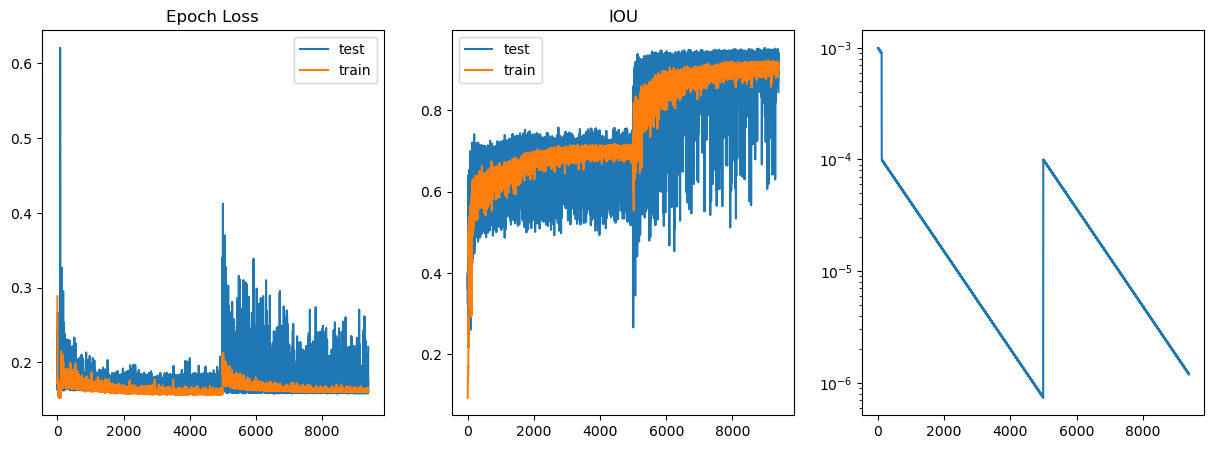

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5 ))

axs[0].plot(np.array(checkpoint['epoch_losses']['test'])/2, label='test')
axs[0].plot(np.array(checkpoint['epoch_losses']['train']),  label='train')
axs[0].set_title("Epoch Loss")
axs[0].legend()

axs[1].plot(np.array(checkpoint['iou_lists']['test'])[:, 1], label='test')
axs[1].plot(np.array(checkpoint['iou_lists']['train'])[:, 1], label='train')
axs[1].set_title("IOU")
axs[1].legend()

axs[2].plot(checkpoint['lr_list'])
axs[2].set_yscale('log')

In [26]:
mydir = r"D:\RECTDNN\processing\2024-11-15_09-31-24\referencing\\"
files = glob.glob(f"{mydir}*.tif")

out_dir = f"{mydir}out\\"

os.makedirs(out_dir, exist_ok=True)

for file_dir in files:
    ou_dir = os.path.join(out_dir, os.path.basename(file_dir))

    image = Image.open(file_dir).convert('L')
    image = np.asarray(image)
    original_shape = image.shape
    
    test, model = run_nontiled_CNN(file_dir, model)

    test = test * 255
    test = test.astype(np.uint8)

    test = cv2.resize(test[1, :, :], (original_shape[1], original_shape[0]), interpolation= cv2.INTER_LINEAR)

    cv2.imwrite(ou_dir, test)

In [16]:
test.shape

(2, 1536, 1536)